In [ ]:
!git clone https://github.com/carlosvasquez3/pyworld2.git

Cloning into 'pyworld2'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 100 (delta 47), reused 69 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 323.41 KiB | 14.70 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
%cd pyworld2

/content/pyworld2/pyworld2/pyworld2


Resultados Finales:
Población (P): 4.24e+09
Relación de contaminación (POLR): 4.25e+00
Inversión de capital (CI): 7.56e+09
Calidad de vida (QL): 7.20e-01
Recursos naturales (NR): 4.29e+11


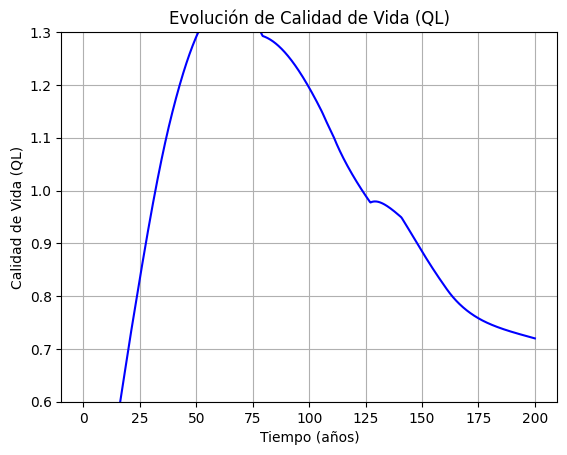

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyworld2 import World2

class World2Model:
    def __init__(self, nr_factor, pols_factor, ciaf_factor, fn_factor, brn_factor,
                 year_min=0, year_max=200, dt=0.2):
        """
        Inicializa el modelo World2 con los parámetros ajustados.

        Parámetros:
        - nr_factor: Factor para la tasa de uso de recursos naturales (NRUN).
        - pols_factor: Factor para la relación de contaminación por persona (POLS).
        - ciaf_factor: Factor para la tasa de inversión de capital (CIAF).
        - fn_factor: Factor para el coeficiente de alimentos (FN).
        - brn_factor: Factor para la tasa normal de nacimientos (BRN).
        - year_min, year_max: Años de inicio y fin de la simulación.
        - dt: Paso temporal.
        """
        self.nr_factor = nr_factor
        self.pols_factor = pols_factor
        self.ciaf_factor = ciaf_factor
        self.fn_factor = fn_factor
        self.brn_factor = brn_factor
        self.year_min = year_min
        self.year_max = year_max
        self.dt = dt
        self.model = None
        self.time = None

    def setup_model(self):
        """Configura el modelo World2 con los parámetros iniciales."""
        model = World2(year_min=self.year_min, year_max=self.year_max, dt=self.dt)

        # Configurar variables de estado
        model.set_state_variables(
            fn=self.fn_factor,            # Coeficiente de alimentos
            pols=self.pols_factor * 3.6e9  # Contaminación por persona
        )

        # Configurar estado inicial
        model.set_initial_state(
            nri=self.nr_factor * 900e9,    # Tasa de uso de recursos naturales
            ciafi=self.ciaf_factor,       # Tasa de inversión de capital
            pi=1.65e9,                    # Población inicial
            poli=self.pols_factor * 0.2e9,  # Contaminación inicial
            cii=self.ciaf_factor * 0.4e9  # Inversión de capital inicial
        )

        # Configurar funciones y simulación
        model.set_table_functions()
        model.set_switch_functions()
        model.brn.value_before_switch = self.brn_factor
        self.model = model

    def simulate(self):
        """Ejecuta la simulación del modelo y almacena resultados."""
        if self.model is None:
            self.setup_model()
        self.model.run()
        self.time = self.model.time
        return {
            "Población (P)": self.model.p,
            "Relación de contaminación (POLR)": self.model.polr,
            "Inversión de capital (CI)": self.model.ci,
            "Calidad de vida (QL)": self.model.ql,
            "Recursos naturales (NR)": self.model.nr
        }

    def plot_simulation(self, variable, label, color, ylim=None):
        if self.time is None or self.model is None:
            raise ValueError("El modelo no se ha ejecutado. Llama a `simulate` primero.")
        plt.plot(self.time, getattr(self.model, variable), label=label, color=color)
        plt.xlabel('Tiempo (años)')
        plt.ylabel(label)
        plt.title(f'Evolución de {label}')
        if ylim:
            plt.ylim(ylim)
        plt.grid(True)
        plt.show()

# Ejemplo de uso
params = [1.0, 1.0, 0.05, 1.25, 0.04]  # Valores iniciales
world2_instance = World2Model(*params)

# Configurar y ejecutar el modelo
results = world2_instance.simulate()

# Imprimir resultados finales de las variables clave
print("Resultados Finales:")
for key, values in results.items():
    print(f"{key}: {values[-1]:.2e}")

# Graficar calidad de vida (QL) con límites ajustados
world2_instance.plot_simulation("ql", "Calidad de Vida (QL)", "blue", ylim=(0.6, 1.3))

# **e-GREEDY**

Parametros iniciales =  [0.25, 0.5, 0.03, 0.8, 0.04]
Recompensa inicial = 0.57367
Parametros finales =  [0.3250753284932325, 0.10075548019482931, 0.01279847757011542, 0.6025572722517688, 0.02107270152167739]
Recompensa final = 7.957063530361388
% Ganancia = 12.87
 


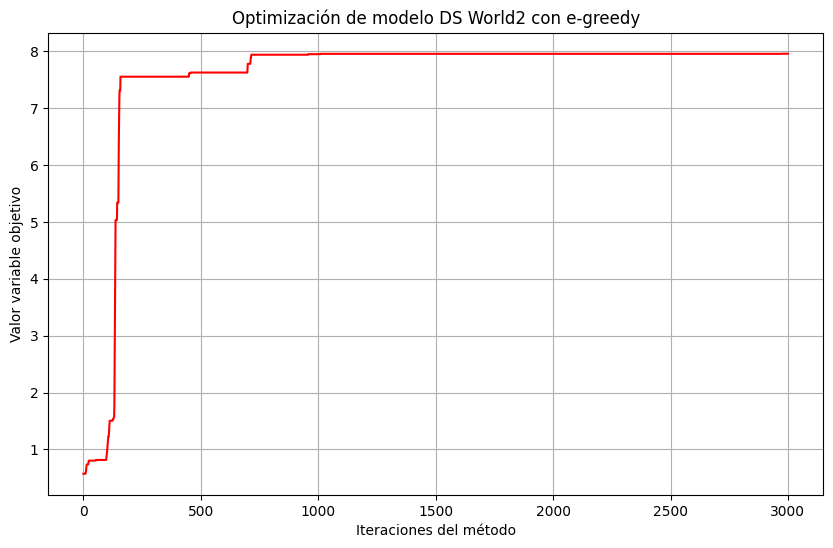

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

##############################################################################################################################
# FUNCIÓN

def Cumple_Limites(parametros, limites):
    for i, valor in enumerate(parametros):
        if not (limites[i][0] <= valor <= limites[i][1]):
            return False
    return True

##############################################################################################################################
# PARÁMETROS

E = 0.1
P = [0.25, 0.5, 0.03, 0.8, 0.04] # Valor inicial de los parametros
fac = [-0.1, -0.05, -0.01, 0, 0.01, 0.05, 0.1] # Posibles cambios que pueden tenre los parámetros
A = len(fac)
Q = np.zeros((A,A,A,A,A)) # Definición de la matriz Q del método K-Armed Bandid
Dim = Q.ndim
Runs = 3000

##############################################################################################################################
# SOLUCIÓN INICIAL

world2_instance = World2Model(*P)
_, _, _, QL, _ = world2_instance.simulate().values()
R_inicial = np.nanmean(QL)
print("Parametros iniciales = ", P)
print("Recompensa inicial =", round(R_inicial,5))

##############################################################################################################################

# PROCESO DE EXPLORAR - EXPLOTAR
corrida=[]
data_acum=[]
y = [0]
y[0] = R_inicial

n_episodios = 1
episodios = []

for j in range(n_episodios):

    P = [0.25, 0.5, 0.03, 0.8, 0.04]
    Lim = [[0.1, 1], [0.1, 1], [0.01, 0.05], [0.6, 1.25], [0.02, 0.04]]
    Q = np.zeros((A,A,A,A,A))

    for i in range(Runs):

        P_previo = list(P)
        world2_instance = World2Model(*P_previo)
        _, _, _, QL_previo, _ = world2_instance.simulate().values()
        R_previo = np.nanmean(QL_previo)

        # Se grafica las ganancias
        y.append(R_previo)

        if E < random.random():  # Explotar
            policy = "Max"
            max_val = np.amax(Q)
            result = np.where(Q == max_val)
            I, J, K, L, M = [result[i][0] for i in range(Dim)]

        else:
            policy = "Rand"
            idxs = [0] * Dim
            I, J, K, L, M = [random.randint(0, A-1) for items in idxs]

        # Asigno un nuevo P de acuerdo a la posición elegida
        P[0] = P[0] * (1+fac[I])
        P[1] = P[1] * (1+fac[J])
        P[2] = P[2] * (1+fac[K])
        P[3] = P[3] * (1+fac[L])
        P[4] = P[4] * (1+fac[M])

        # Verifico que esta nueva solución P no viole los límites de factibilidad
        if Cumple_Limites(P, Lim) == True:
            lim_cump = "N"
            # Si sí es una solución factible calculo su recompensa y guardo esta posición
            world2_instance = World2Model(*P)
            _, _, _, QL_actual, _ = world2_instance.simulate().values()
            R_actual = np.nanmean(QL_actual)

            Q[I][J][K][L][M] += ((R_actual - R_previo) / R_previo)
            # Verifico que la nueva solución sea mejor que la mejor solución anterior, sino, me quedo con la solución mejor.
            if R_previo >= R_actual:
                P = P_previo
        else:
            lim_cump = "S"
            Q[I][J][K][L][M] += -100
            P = P_previo

        corrida = [j] + [R_previo] + [R_actual] + P_previo + [fac[I]] + [fac[J]] + [fac[K]] + [fac[L]] + [fac[M]] + P + [policy] + [lim_cump]
        data_acum.append(corrida)

data_acum = pd.DataFrame(data_acum, columns=['Episodio', 'R_actual', 'R_previo', 'P1_p', 'P2_p', 'P3_p', 'P4_p', 'P5_p', 'A1', 'A2', 'A3', 'A4', 'A5', 'P1_a', 'P2_a', 'P3_a', 'P4_a', 'P5_a', 'Policy', 'cumple_lim'])
data_acum.to_csv('datos_egreedy_world2.csv')

##############################################################################################################################
# SOLUCIÓN FINAL

print("Parametros finales = ", P)
world2_instance = World2Model(*P)
_, _, _, QL_final, _ = world2_instance.simulate().values()
R_final = np.nanmean(QL_final)
print("Recompensa final =", R_final)
print(f'% Ganancia = {round((y[Runs-1] - y[0]) / y[0], 2)}')
print(" ")

##############################################################################################################################
# GRÁFICO

plt.figure(figsize=(10, 6))
plt.grid(True)  # Mostrar grilla
plt.title('Optimización de modelo DS World2 con e-greedy')
plt.xlabel('Iteraciones del método')
plt.ylabel('Valor variable objetivo')
x = list(range(0, Runs + 1))
plt.plot(x, y, color='red')

plt.show()

In [ ]:
data_acum

,Episodio,R_actual,R_previo,P1_p,P2_p,P3_p,P4_p,P5_p,A1,A2,A3,A4,A5,P1_a,P2_a,P3_a,P4_a,P5_a,Policy,cumple_lim
0,0,0.573667,0.632413,0.250000,0.500000,0.030000,0.800000,0.040000,0.05,0.0,-0.01,0.00,-0.10,0.262500,0.500000,0.029700,0.800000,0.036000,Rand,N
1,0,0.632413,0.705123,0.262500,0.500000,0.029700,0.800000,0.036000,0.05,0.0,-0.01,0.00,-0.10,0.275625,0.500000,0.029403,0.800000,0.032400,Max,N
2,0,0.705123,0.797205,0.275625,0.500000,0.029403,0.800000,0.032400,0.05,0.0,-0.01,0.00,-0.10,0.289406,0.500000,0.029109,0.800000,0.029160,Max,N
3,0,0.797205,0.687129,0.289406,0.500000,0.029109,0.800000,0.029160,-0.05,-0.1,-0.01,-0.05,0.10,0.289406,0.500000,0.029109,0.800000,0.029160,Rand,N
4,0,0.797205,0.908384,0.289406,0.500000,0.029109,0.800000,0.029160,0.05,0.0,-0.01,0.00,-0.10,0.303877,0.500000,0.028818,0.800000,0.026244,Max,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,4,8.174926,7.964721,0.472852,0.100527,0.045182,0.687512,0.020003,-0.10,0.1,-0.10,0.10,0.01,0.472852,0.100527,0.045182,0.687512,0.020003,Max,N
11996,4,8.174926,7.939267,0.472852,0.100527,0.045182,0.687512,0.020003,-0.10,0.1,-0.10,0.10,0.05,0.472852,0.100527,0.045182,0.687512,0.020003,Max,N
11997,4,8.174926,7.914977,0.472852,0.100527,0.045182,0.687512,0.020003,-0.10,0.1,-0.10,0.10,0.10,0.472852,0.100527,0.045182,0.687512,0.020003,Max,N
11998,4,8.174926,7.914977,0.472852,0.100527,0.045182,0.687512,0.020003,-0.10,0.1,-0.05,-0.10,-0.10,0.472852,0.100527,0.045182,0.687512,0.020003,Max,S
